# Collect & plot results of parallellized ISRSA

In [1]:
import warnings, os, sys, glob, matplotlib, scipy
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
matplotlib.rcParams['pdf.fonttype'] = 42 #To make text readable by Illustrator
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, collapse_mask
from nltools.stats import threshold, fdr
base_dir = '/project/3014018.02/analysis_mri/DataSharingCollection/'

## Load parcellation

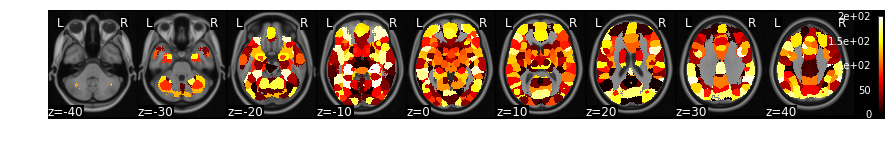

In [3]:
nparcel = 200
roi = Brain_Data(os.path.join(base_dir,
      'Data/6.Parcellation/whole_brain_cluster_labels_PCA=100_k=%s.nii.gz' % nparcel))
roi.plot()
roi_x = expand_mask(roi)

## Collect results

X4


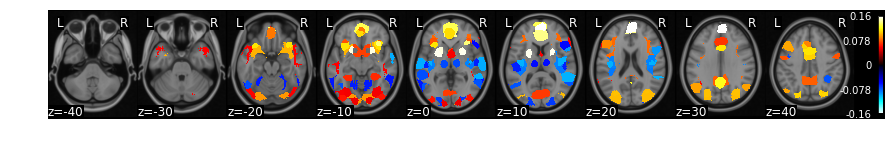

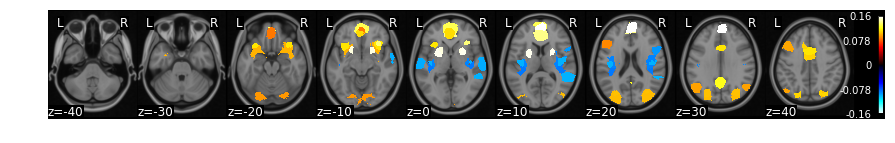

In [14]:
screen = 'Mult' # 'Multiplier screen' is called 'decision screen' in paper
thresh = 0.05
permutation_method = 'vector'
conds = ['X4']

for cond in conds:
    print cond

    roi_r = roi.copy()
    roi_p = roi.copy()

    results_allparcels = pd.DataFrame()
    for parcel in range(nparcel):
        parcelDat = pd.read_csv(os.path.join(base_dir,
           'Results/3.fMRI-ISRSA/IS-RSA/IS-RSA_nparcel-%i_perm-%s_%s%s/parcel%03d.csv'%(
            nparcel,permutation_method,screen,cond,parcel)),index_col=0)
        results_allparcels = results_allparcels.append(parcelDat,ignore_index=True)
        roi_r.data[roi_x[parcel].data>0] = float(parcelDat['r'])*1000000
        roi_p.data[roi_x[parcel].data>0] = float(parcelDat['p'])*1000000
    results_allparcels.to_csv(os.path.join(base_dir,
               'Results/3.fMRI-ISRSA/IS-RSA/IS-RSA_nparcel-%i_perm-%s_%s%s'%(
            nparcel,permutation_method,screen,cond),'allparcels.csv'))
    roi_r.data = roi_r.data.astype(float)/1000000
    roi_p.data = roi_p.data.astype(float)/1000000
#         roi_r.plot()
#         roi_p.plot()
    roi_r.write(os.path.join(base_dir,
         'Results/3.fMRI-ISRSA/IS-RSA/Maps/Maps_nparcel-%i_perm-%s/%s%s_R.nii.gz' % (
            nparcel,permutation_method,screen,cond)))
    roi_p.write(os.path.join(base_dir,
         'Results/3.fMRI-ISRSA/IS-RSA/Maps/Maps_nparcel-%i_perm-%s/%s%s_P.nii.gz' % (
            nparcel,permutation_method,screen,cond)))

    fdr_thresh = fdr(np.array(results_allparcels['p']),thresh)
    bonf_thresh = thresh/nparcel
    threshs_all = {'bonf':bonf_thresh,'fdr':fdr_thresh}
    for thresh_type in threshs_all:
        roi_r_thr = threshold(stat=roi_r,p=roi_p,thr=threshs_all[thresh_type])
        roi_r_thr.plot()

        plt.savefig(os.path.join(base_dir,
             'Results/3.fMRI-ISRSA/IS-RSA/Maps/Maps_nparcel-%i_perm-%s/%s%s_R-thr-%.2f-%s.png' % (
                nparcel,permutation_method,screen,cond,thresh,thresh_type)))
        plt.show()
        roi_r_thr.write(os.path.join(base_dir,
             'Results/3.fMRI-ISRSA/IS-RSA/Maps/Maps_nparcel-%i_perm-%s/%s%s_R-thr-%.2f-%s.nii.gz' % (
                nparcel,permutation_method,screen,cond,thresh,thresh_type)))
        roi_r_thr_posOnly = roi_r_thr.copy()
        roi_r_thr_posOnly.data[roi_r_thr_posOnly.data<0] = 0
        roi_r_thr_posOnly.write(os.path.join(base_dir,
             'Results/3.fMRI-ISRSA/IS-RSA/Maps/Maps_nparcel-%i_perm-%s/%s%s_R-thr-%.2f-%s-posOnly.nii.gz' % (
                nparcel,permutation_method,screen,cond,thresh,thresh_type)))

In [5]:
# How many significant effects?
import nltools;

screen = 'Mult'
sampleChoice = 'full'
groupExclude = 'none'#,'GR','GA','IA','MO']
thresh = 0.05
nparcel = 200
thresh_type = 'bonf'
permutation_method = 'vector'
cond = 'X4'

results = pd.read_csv(os.path.join(base_dir,
   'Results/3.fMRI-ISRSA/IS-RSA/IS-RSA_nparcel-%i_perm-%s_%s%s'%(
    nparcel,permutation_method,screen,cond),'allparcels.csv'),
                     index_col=0)

if thresh_type == 'fdr':
    results['sig'] = results['p']<=(fdr(np.array(results['p']),0.05))
elif thresh_type == 'bonf':
    results['sig'] = results['p']<=(0.05/nparcel)

results['sig_pos'] = np.multiply(results['sig'],results['r']>0)

results.sig_pos.sum()

27